#### Riccardo Cusinato - 3627460
#### Giacomo Barzon - 3626438
#### Damiano Sgarbossa - 3623971  

# Exercise 1 - Particle-mesh mapping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## 1.1. Weight coefficients and shape functions

In this exercise we'll consider the (0,0) cell as the one in the top-left corner of the grid in the position $(-H,+H)$

Given the coordinates of the particle i: $(X_i,Y_i)$ we can compute the expression for the indices $(k,l)$ as:
$$(k,l) = \bigg(floor\bigg(\bigg(1+\dfrac{X_i}{H}\bigg)\dfrac{K}{2}\bigg), floor\bigg(\bigg(1-\dfrac{Y_i}{H}\bigg)\dfrac{K}{2}\bigg)\bigg)$$
where in the previous formula the $floor()$ function is the integer part of its argument.

To compute the numerical form of the $\rho (x,y)$ as $\rho_{k,l}$ we can use the following formula:
$$\rho_{k,l} = \dfrac{1}{(2H/K)^2}\sum_{i=1}^N m_i W\big(\vec{x_i}-\vec{x_p}\big)=\dfrac{1}{(2H/K)^2}\sum_{i=1}^N m_i \Pi \bigg(\dfrac{\vec{x_i}-\vec{x_p}}{2H/K}\bigg)$$
where $\vec{x_p}$ is the vector of the position of the cell $(k,l)$ that is: $\vec{x_p} = \bigg(\dfrac{2H}{K}k-H, H-\dfrac{2H}{K}l\bigg)$
where the $\Pi()$ function is the Top-Hat function which gives one when the particle i is inside the cell $\vec{p}=(k,l)$ and zero otherwise.

## 1.2. Elements of W for the first and second-order method

Using the definition of the parameters: $(\varepsilon_x,\varepsilon_y) = \big(\dfrac{(H+X)K}{2H}-k, \dfrac{(H-Y)K}{2H}-l\big)$ we can compute the elements of the matrix W for the first and the second order method (using the sequential description).
For both the calculations we want to compute the overlap between the shape function (so the 2d-CIC or the 2d-TSC) and the nearest neighbors of the particle (the 8 squared cells around the cell in which is situated the point $(X_i,Y_i)$ and that same cell).
#### First order:
In this case we can easily see that in each direction (x or y) the shape function is overlapped only with a maximum of 2 cells, that's why we must include in the formulas the $\theta$ of Heaviside, to select only these overlapped cells.
We'll do the reasoning only for the direction x because the one for the y direction is analogue.

If the particle is in the left half of the central cell then the overlap area with the cells [:,0] is (0.5-ex) while the overlap area with the central cells [:,1] is (0.5+ex), these values are multiplied by $\theta (0.5-ex)$ to select the "left" cells.
If the particle is in the right half of the central cell then the overlap area with the cells [:,2] is (ex-0.5) while the overlap area with the central cells [:,1] is (1.5-ex), these values are multiplied by $\theta (ex-0.5)$ to select the "right" cells.

        W[:,0]*= (0.5-ex)*np.heaviside((0.5-ex),0)
        W[:,1]*= (0.5+ex)*np.heaviside((0.5-ex),0) + (1.5-ex)*np.heaviside((ex-0.5),1)
        W[:,2]*= (ex-0.5)*np.heaviside((ex-0.5),0)
        W[0,:]*= (0.5-ey)*np.heaviside((0.5-ey),0)
        W[1,:]*= (0.5+ey)*np.heaviside((0.5-ey),0) + (1.5-ey)*np.heaviside((ey-0.5),1)
        W[2,:]*= (ey-0.5)*np.heaviside((ey-0.5),0)

Here ve can see that to include the boundaries of the cells in the corrected way we selected the thetas of Heaviside to have value 0 when the argument inside is 0 with exception of the 2 of them in the central cells (when the particle is on the right half of the central cell) where they assume the value 1; this last decision was made to be able to include all the points with $X_i = 0.5 $ or the ones with $Y_i = 0.5 $.
#### Second order:
In this case we can see that in each direction (x or y) the shape function is overlapped with all of the 3 cells so we don't need to include the thetas of Heaviside.
We'll do the reasoning only for the direction x because the one for the y direction is analogue.
The overlap with the left cells [:,0] is the area of the triangle of catheti (1-ex) which is: 0.5(1-ex)(1-ex) while the overlap with the right ones [:,2] is the area of the triangle of catheti (ex) which is: 0.5(ex)(ex), finally the overlap with the central cells [:,1] is 1 minus the area of the 2 triangles we already computed (because of the normalization of the shape function).

        W[:,0]*= 0.5*(1-ex)**2
        W[:,1]*= 0.5-ex**2+ex
        W[:,2]*= 0.5*ex**2
        W[0,:]*= 0.5*(1-ey)**2
        W[1,:]*= 0.5-ey**2+ey
        W[2,:]*= 0.5*ey**2

## 1.3. Density map from a set of particles in 2D

In [2]:
def Mesh_map (X,Y,H,K,N,m,order):
    if (np.abs(X)>(H-2*H/K) or np.abs(Y)>(H-2*H/K)):   # Check if particles is not on borders
        print('Error, wrong position')
        return False,False,False
    
    k,l = np.floor((1.+X/H)*K*0.5), np.floor((1.-Y/H)*K*0.5)   # compute cells indices
    
    ex, ey = 0.5*(H+X)*K/H-k, 0.5*(H-Y)*K/H-l         # compute distances inside cell
    
    W = np.ones((3,3))           # Now compute weights matrices for each order 
    
    if order == 0 :
        W = np.zeros((3,3))
        W[1,1] = 1
        
    elif order == 1 :
        W[:,0]*= (0.5-ex)*np.heaviside((0.5-ex),0)
        W[:,1]*= (0.5+ex)*np.heaviside((0.5-ex),0) + (1.5-ex)*np.heaviside((ex-0.5),1) 
        W[:,2]*= (ex-0.5)*np.heaviside((ex-0.5),0)                                     
        W[0,:]*= (0.5-ey)*np.heaviside((0.5-ey),0)
        W[1,:]*= (0.5+ey)*np.heaviside((0.5-ey),0) + (1.5-ey)*np.heaviside((ey-0.5),1)
        W[2,:]*= (ey-0.5)*np.heaviside((ey-0.5),0)                                    
        
    elif order == 2 :
        W[:,0]*= 0.5+0.5*ex**2-ex
        W[:,1]*= 0.5-ex**2+ex
        W[:,2]*= 0.5*ex**2
        W[0,:]*= 0.5+0.5*ey**2-ey
        W[1,:]*= 0.5-ey**2+ey
        W[2,:]*= 0.5*ey**2
        
    return int(k),int(l),W      # return indexes and weights

### Test of the correct functioning of the W function

In [3]:
# Parameters of grid

H = 15.
K = 30
N = 1
M = 2.
m = M/N

start = -H
end = H

np.random.seed(1)

# Set up some points

rho = np.zeros((K,K,3))
XY = np.array([[4.36,2.,4.5],
               [4.29,7.,7.5]])

# And place into matrix computing weights

for j in range(3):
    for i in range(XY.shape[1]):
        k, l, W = Mesh_map (XY[0,i], XY[1,i], H, K, N, m, j)
        rho[l-1:l+2, k-1:k+2, j] += W*m/(2*H/K)**2               
        print('\n Positions and matrix W for order: ', j)
        print('(k,l) = ({},{})'.format(k,l))
        print(W)


 Positions and matrix W for order:  0
(k,l) = (19,10)
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

 Positions and matrix W for order:  0
(k,l) = (17,8)
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

 Positions and matrix W for order:  0
(k,l) = (19,7)
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

 Positions and matrix W for order:  1
(k,l) = (19,10)
[[-0.     -0.      0.    ]
 [ 0.1106  0.6794 -0.    ]
 [ 0.0294  0.1806 -0.    ]]

 Positions and matrix W for order:  1
(k,l) = (17,8)
[[ 0.25  0.25 -0.  ]
 [ 0.25  0.25 -0.  ]
 [-0.   -0.    0.  ]]

 Positions and matrix W for order:  1
(k,l) = (19,7)
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

 Positions and matrix W for order:  2
(k,l) = (19,10)
[[0.00861184 0.03071332 0.00272484]
 [0.14456832 0.51558936 0.04574232]
 [0.05161984 0.18409732 0.01633284]]

 Positions and matrix W for order:  2
(k,l) = (17,8)
[[0.25 0.25 0.  ]
 [0.25 0.25 0.  ]
 [0.   0.   0.  ]]

 Positions and matrix W for order:  2
(k,l) = (19,7)
[[0.015625 0.09375  0.015625]
 [0.09375  0.5625   0.0

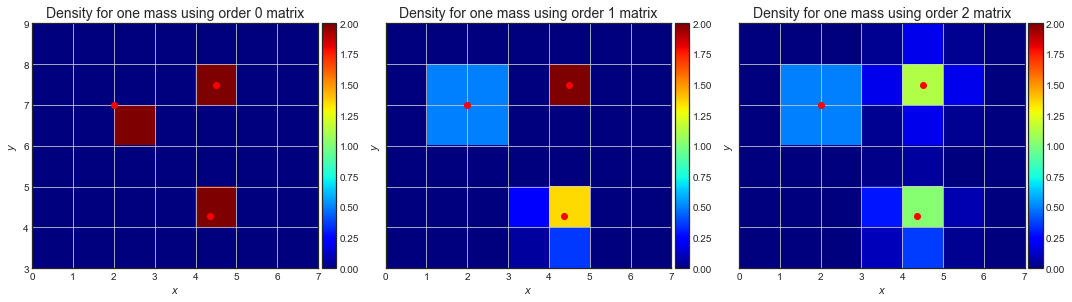

In [4]:
# Plot results

plt.style.use('seaborn-white')

fig, ax = plt.subplots(1,3,sharey=True)
fig = plt.gcf()
fig.set_size_inches(15,10)

for i in range(rho.shape[2]):
    im = ax[i].imshow(rho[:,:,i], extent=[start, end, end, start], origin='lower', cmap='jet', vmin=rho.min(), vmax=rho.max())

    ax[i].plot(XY[0,:],XY[1,:], 'ro')
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_title("Density for one mass using order %i matrix" %i, fontsize = 14)
    ax[i].grid()
    ax[i].invert_yaxis()
    ax[i].set_xlim(0,7)
    ax[i].set_ylim(3,9)
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
plt.tight_layout()
plt.show()

### Now compute for 100 randomly placed particles

In [5]:
N = 100
mean = np.array([0,0])
sigma = np.array([4.,4.])
cov = np.diag(sigma**2)
XY = np.random.multivariate_normal(mean, cov, N)

for i in range(N):
    if i>=N : break
    if (np.abs(XY[i,0])>(H-2*H/K) or np.abs(XY[i,1])>(H-2*H/K)) :
        print('Rejected value: (x,y) = ({},{})'.format(XY[i,0],XY[i,1]))
        XY = np.delete(XY,i,0)
        N = XY.shape[0]
        print('New lenght of vector of masses: ', N)

M = 2.
m = M/N

rho = np.zeros((K,K,3))

for j in range(3):
    for i in range(XY.shape[0]):
        k,l,W = Mesh_map (XY[i,0],XY[i,1],H,K,N,m,j)
        rho[l-1:l+2,k-1:k+2,j] += W
        
rho = rho * m/(2*H/K)**2

Multivariate gaussian distribution of mean (x,y) = (0,0) and sigma (sx,sy) = (4.0,4.0)


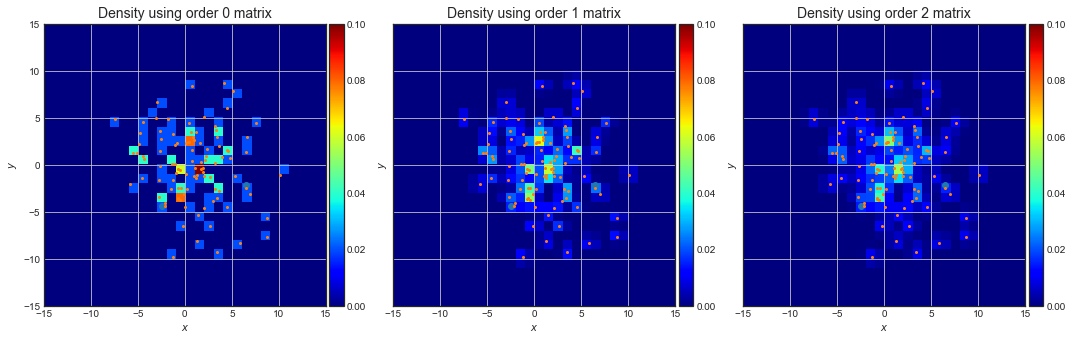

In [6]:
# Plot results
print('Multivariate gaussian distribution of mean (x,y) = ({},{}) and sigma (sx,sy) = ({},{})'.format(mean[0],mean[1],sigma[0],sigma[1]))

plt.style.use('seaborn-white')

fig, ax = plt.subplots(1,3,sharey=True)
fig = plt.gcf()
fig.set_size_inches(15,10)

for i in range(rho.shape[2]):
    im = ax[i].imshow(rho[:,:,i], extent=[start, end, end, start], origin='lower', cmap='jet', vmin=rho.min(), vmax=rho.max())

    ax[i].plot(XY[0,:],XY[1,:], 'o')
    ax[i].plot(XY[:,0],XY[:,1], 'o', markersize=2)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_title("Density using order %i matrix" %i, fontsize = 14)
    ax[i].grid()
    ax[i].invert_yaxis()
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
plt.tight_layout()
plt.show()

In [7]:
print('Sum of all the points on rho multiplied by the area of the single cells (= total mass): ')
print('order 0: ', np.sum(rho[:,:,0])*(2*H/K)**2)
print('order 1: ', np.sum(rho[:,:,1])*(2*H/K)**2)
print('order 2: ', np.sum(rho[:,:,2])*(2*H/K)**2)

Sum of all the points on rho multiplied by the area of the single cells (= total mass): 
order 0:  2.0
order 1:  2.0
order 2:  2.0


Here, few particles are rejected. Moreover we defined the mass for each particle after having rejected the uncorrect ones, so the mass is actually "conserved".

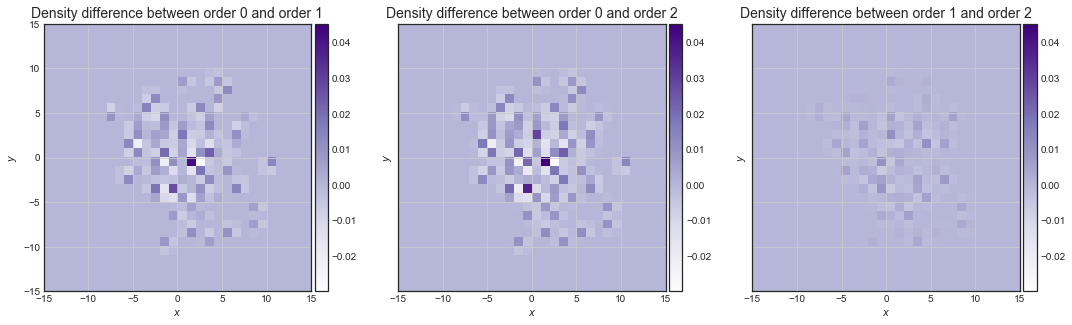

In [8]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots(1,3,sharey=True)
fig = plt.gcf()
fig.set_size_inches(15,10)

index = np.array(([0,1], [0,2], [1,2]))

vmin = (rho[:,:,0]-rho[:,:,2]).min()
vmax = (rho[:,:,0]-rho[:,:,2]).max()

for i in range(len(index)):
    im = ax[i].imshow(rho[:,:,index[i,0]] - rho[:,:,index[i,1]], extent=[start, end, end, start], origin='lower', cmap='Purples', vmin=vmin, vmax=vmax)

    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_title(f"Density difference between order {index[i,0]} and order {index[i,1]}", fontsize = 14)
    ax[i].grid()
    ax[i].invert_yaxis()
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
plt.tight_layout()
plt.show()

Here we can also analyze the distribution of the difference for the computation of the mass in each cell with the different orders of accuracy. In particular the standard deviation of this sample can be computed and compared: 

In [9]:
print('Total mass sigma of the difference between different orders:\n ')
for i in range(len(index)):
    print(f'Sigma of mass difference between order {index[i,0]} and order {index[i,1]}: %.4f' %(np.sqrt(np.sum( (rho[:,:,index[i,0]]-rho[:,:,index[i,1]])**2))*(2*H/K)**2))

Total mass sigma of the difference between different orders:
 
Sigma of mass difference between order 0 and order 1: 0.1186
Sigma of mass difference between order 0 and order 2: 0.1390
Sigma of mass difference between order 1 and order 2: 0.0397


As expected, the major difference is found when orders 0 and 2 are compared, while there's little difference between orders 1 and 2.

### Now compute with 10000 particles

Rejected value: (x,y) = (-6.549798372033367,15.834410816151854)
New lenght of vector of masses:  9999
Rejected value: (x,y) = (-1.937110082291707,14.960995614818357)
New lenght of vector of masses:  9998
Rejected value: (x,y) = (-0.6413396877565328,16.10739617818951)
New lenght of vector of masses:  9997
Rejected value: (x,y) = (14.453108028332592,3.59579473263137)
New lenght of vector of masses:  9996
Rejected value: (x,y) = (14.243493282822195,-0.9187850946141415)
New lenght of vector of masses:  9995
Rejected value: (x,y) = (-14.62576039701918,-4.9720357424553345)
New lenght of vector of masses:  9994
Rejected value: (x,y) = (14.242450590689671,-0.21809996799551284)
New lenght of vector of masses:  9993
Rejected value: (x,y) = (16.672470711820377,-4.470455075940545)
New lenght of vector of masses:  9992
Rejected value: (x,y) = (15.337524083642812,4.148191413260736)
New lenght of vector of masses:  9991

 Multivariate gaussian distribution of mean (x,y) = (0,0) and sigma (sx,sy) = (4

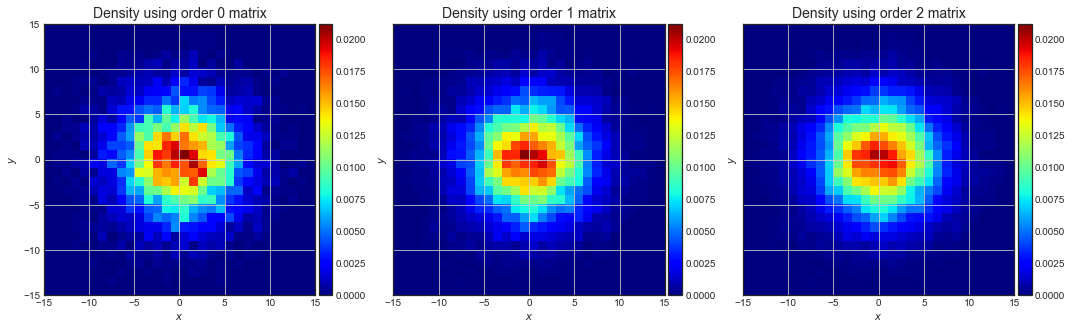

In [10]:
N = 10000
mean = np.array([0,0])
sigma = np.array([4.,4.])
cov = np.diag(sigma**2)
XY = np.random.multivariate_normal(mean, cov, N)

for i in range(N):
    if i>=N : break
    if (np.abs(XY[i,0])>(H-2*H/K) or np.abs(XY[i,1])>(H-2*H/K)) :
        print('Rejected value: (x,y) = ({},{})'.format(XY[i,0],XY[i,1]))
        XY = np.delete(XY,i,0)
        i -=1
        N = XY.shape[0]
        print('New lenght of vector of masses: ', N)
        
        #np.abs(X)>(H-2*H/K) or np.abs(Y)>(H-2*H/K)

M = 2.
m = M/N

rho = np.zeros((K,K,3))
for j in range(3):
    for i in range(XY.shape[0]):
        k,l,W = Mesh_map (XY[i,0],XY[i,1],H,K,N,m,j)
        rho[l-1:l+2,k-1:k+2,j] += W                    
rho = rho *m/(2*H/K)**2

# Plot results

plt.style.use('seaborn-white')
print('\n Multivariate gaussian distribution of mean (x,y) = ({},{}) and sigma (sx,sy) = ({},{})'.format(mean[0],mean[1],sigma[0],sigma[1]))
fig, ax = plt.subplots(1,3,sharey=True)
fig = plt.gcf()
fig.set_size_inches(15,10)

for i in range(rho.shape[2]):
    im = ax[i].imshow(rho[:,:,i], extent=[start, end, end, start], origin='lower', cmap='jet', vmin=rho.min(), vmax=rho.max())

    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_title("Density using order %i matrix" %i, fontsize = 14)
    ax[i].grid()
    ax[i].invert_yaxis()
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
plt.tight_layout()
plt.show()

In [11]:
print('Sum of all the points on rho multiplied by the area of the single cells (= total mass): ')
print('order 0: ', np.sum(rho[:,:,0])*(2*H/K)**2)
print('order 1: ', np.sum(rho[:,:,1])*(2*H/K)**2)
print('order 2: ', np.sum(rho[:,:,2])*(2*H/K)**2)

Sum of all the points on rho multiplied by the area of the single cells (= total mass): 
order 0:  2.0
order 1:  2.0
order 2:  2.0


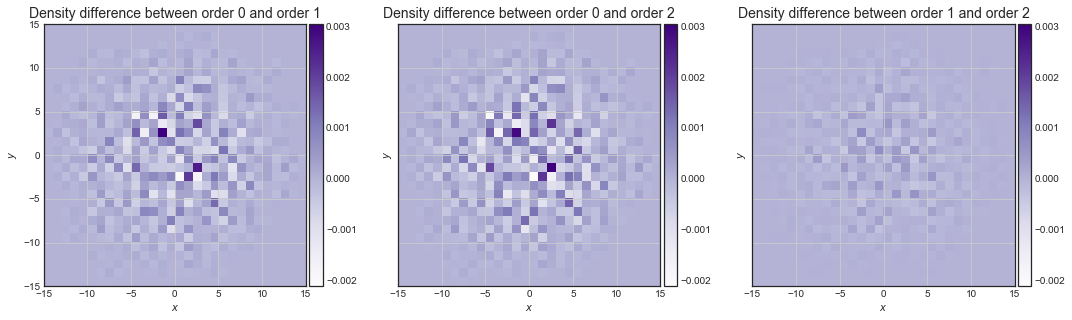

In [12]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots(1,3,sharey=True)
fig = plt.gcf()
fig.set_size_inches(15,10)

index = np.array(([0,1], [0,2], [1,2]))

vmin = (rho[:,:,0]-rho[:,:,2]).min()
vmax = (rho[:,:,0]-rho[:,:,2]).max()

for i in range(len(index)):
    im = ax[i].imshow(rho[:,:,index[i,0]] - rho[:,:,index[i,1]], extent=[start, end, end, start], origin='lower', cmap='Purples', vmin=vmin, vmax=vmax)

    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_title(f"Density difference between order {index[i,0]} and order {index[i,1]}", fontsize = 14)
    ax[i].grid()
    ax[i].invert_yaxis()
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
plt.tight_layout()
plt.show()

In [13]:
print('Total mass sigma of the difference between different orders:\n ')
for i in range(len(index)):
    print(f'Sigma of mass difference between order {index[i,0]} and order {index[i,1]}: %.4f' %(np.sqrt(np.sum( (rho[:,:,index[i,0]]-rho[:,:,index[i,1]])**2))*(2*H/K)**2))

Total mass sigma of the difference between different orders:
 
Sigma of mass difference between order 0 and order 1: 0.0114
Sigma of mass difference between order 0 and order 2: 0.0129
Sigma of mass difference between order 1 and order 2: 0.0037


Here the difference is one order of magnitude with respect to the previous case and this can be explained by the fact that now the number of particles is 100 times more than the previous case and these particles can be distributed along two directions; so, for each cell there are (on average) 10 more particles and the mass difference between different methods is reduced by 10 times.